In [18]:
import emnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import sklearn
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

In [2]:
emnist.list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [3]:
images, labels = emnist.extract_training_samples('balanced')

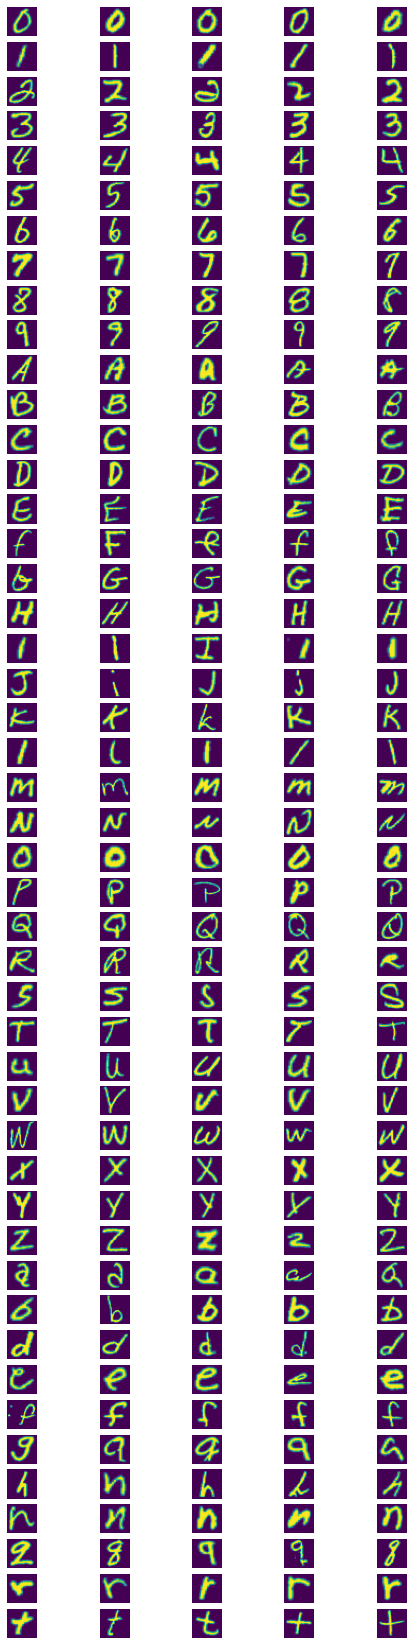

In [4]:
f, axes = plt.subplots(47, 5, figsize = (8, 30))
for i in range(47):
    index = np.where(labels == i)[0][:5]
    for j in range(5):
        axes[i][j].imshow(images[index[j]])
        axes[i][j].axis('off')

In [5]:
def seperate_emnist(n, verbose = False):
    assert (0<n<47)
    if verbose: print("======= Loading emnist data ... =======")
    seperate = np.unique(labels)
    if verbose: print("Label set: ", seperate)
    np.random.shuffle(seperate)
    if verbose: print("Label set (after shuffle): ", seperate)
    train_pick = np.where(np.isin(labels, seperate[:n]))[0]
    test_pick = np.where(np.isin(labels, seperate[n:]))[0]
    train_images = images[train_pick, :, :]
    train_labels = labels[train_pick]
    test_images = images[test_pick, :, :]
    test_labels = labels[test_pick]
    if verbose: print("Output shape: ", [i.shape for i in [train_images, train_labels, test_images, test_labels]])
    if verbose: print("Train labels: ", np.unique(train_labels))
    if verbose: print("Test labels: ", np.unique(test_labels))
    if verbose: print("======= Finished loading. =======")
    return train_images/255, train_labels, test_images/255, test_labels    

In [6]:
def seperate_fewshot(test_images, test_labels, n):
    oneshot_data = []
    classify_data = []
    for label in np.unique(test_labels):
        for num in np.random.choice(np.where(test_labels == label)[0], n, False):
            oneshot_data.append(num)
    temp = set(oneshot_data)
    for i in range(len(test_labels)):
        if not i in temp: classify_data.append(i)
    oneshot_images = test_images[oneshot_data]
    oneshot_labels = test_labels[oneshot_data]
    classify_images = test_images[classify_data]
    classify_labels = test_labels[classify_data]
    return oneshot_images, oneshot_labels, classify_images, classify_labels

In [7]:
def seperate_oneshot(test_images, test_labels):
    return seperate_fewshot(test_images, test_labels, 1)

In [8]:
def nonlinear_autoencoder(input_size, code_size: int):
    """
    Instanciate and compiles an autoencoder, returns both the autoencoder and just the encoder

    :param int or tuple input_size: shape of the input samples
    :param int code_size: dimension on which to project the original data
    :return: autoencoder, encoder
    """
    # YOUR CODE HERE
    encoder = keras.Sequential([
        keras.layers.Dense(input_size//4, activation='ReLU'),
        keras.layers.Dense(code_size, activation='ReLU'),
    ])
    
    decoder = keras.Sequential([
        keras.layers.Dense(input_size//4, activation='ReLU'),
        keras.layers.Dense(input_size),
    ])
    
    inputs = keras.Input(shape=(input_size,))
    outputs = decoder(encoder(inputs))
    autoencoder = keras.Model(inputs=inputs, outputs=outputs)
    
    autoencoder.compile(optimizer='Adam', loss='MSE')
    return autoencoder, encoder

In [15]:
def test_NLE_emnist(n, n_components = 32, verbose=False, train=1):
    train_images, train_labels, test_images, test_labels = seperate_emnist(n, verbose)
    train_images = train_images.reshape(-1, 28*28)
    test_images = test_images.reshape(-1, 28*28)
    oneshot_images, oneshot_labels, classify_images, classify_labels = seperate_fewshot(test_images, test_labels, train)
    if verbose: print("======= NLE_emnist: Training and evaluating ... =======")
    if verbose: print("Knowledge labels: ", np.unique(train_labels))
    if verbose: print("Evaluating labels: ", np.unique(oneshot_labels))
    autoencoder, encoder = nonlinear_autoencoder(28*28, n_components)
    autoencoder.fit(train_images, train_images, epochs=10)
    oneshot_images = encoder(oneshot_images)
    classify_images = encoder(classify_images)
    nn = min(train, 5)
    neigh = KNeighborsClassifier(n_neighbors = nn)
    neigh.fit(oneshot_images, oneshot_labels)
    pred = neigh.predict(classify_images)
    if verbose: print("Accuracy: ", np.sum(pred == classify_labels)/len(classify_labels))
    if verbose: print("======= NLE_emnist: Finished =======")
    return np.sum(pred == classify_labels)/len(classify_labels)

In [17]:
test_NLE_emnist(40, 32, True, 1)

======= Loading emnist data ... =======
Label set:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Label set (after shuffle):  [22 34 40 19 15 27 13  1 29  4 36 37  2 11  7 18  0  3 31 32 20 14 10 44
 23 33 12 28  5 42 39 43 26 21 25  6 38 24 35  9 17 41 46 16  8 45 30]
Output shape:  [(96000, 28, 28), (96000,), (16800, 28, 28), (16800,)]
Train labels:  [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 18 19 20 21 22 23 24 25 26
 27 28 29 31 32 33 34 35 36 37 38 39 40 42 43 44]
Test labels:  [ 8 16 17 30 41 45 46]
======= Finished loading. =======
======= NLE_emnist: Training and evaluating ... =======
Knowledge labels:  [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 18 19 20 21 22 23 24 25 26
 27 28 29 31 32 33 34 35 36 37 38 39 40 42 43 44]
Evaluating labels:  [ 8 16 17 30 41 45 46]
Epoch 1/10
3000/3000 [==============================] - 10s 3ms/step - loss: 0.0309
Epoch 2/10
3000/3000 [======

0.49979157982492706

In [20]:
def test_NLEandPCA_emnist(n, n_components = 32, verbose=False, train=1):
    train_images, train_labels, test_images, test_labels = seperate_emnist(n, verbose)
    train_images = train_images.reshape(-1, 28*28)
    test_images = test_images.reshape(-1, 28*28)
    oneshot_images, oneshot_labels, classify_images, classify_labels = seperate_fewshot(test_images, test_labels, train)
    if verbose: print("======= NLE/PCA_emnist: Training and evaluating ... =======")
    if verbose: print("Knowledge labels: ", np.unique(train_labels))
    if verbose: print("Evaluating labels: ", np.unique(oneshot_labels))

    pca = PCA(n_components=n_components)
    pca.fit(X=train_images)
    oneshot_images_pca = pca.transform(oneshot_images)
    classify_images_pca = pca.transform(classify_images)
    nn = min(train, 5)
    neigh = KNeighborsClassifier(n_neighbors = nn)
    neigh.fit(oneshot_images_pca, oneshot_labels)
    pred = neigh.predict(classify_images_pca)
    output_pca = np.sum(pred == classify_labels)/len(classify_labels)
    if verbose: print("PCA accuracy: ", output_pca)

    autoencoder, encoder = nonlinear_autoencoder(28*28, n_components)
    autoencoder.fit(train_images, train_images, epochs=10)
    oneshot_images = encoder(oneshot_images)
    classify_images = encoder(classify_images)
    nn = min(train, 5)
    neigh = KNeighborsClassifier(n_neighbors = nn)
    neigh.fit(oneshot_images, oneshot_labels)
    pred = neigh.predict(classify_images)
    if verbose: print("NLE accuracy: ", np.sum(pred == classify_labels)/len(classify_labels))
    if verbose: print("======= NLE/PCA_emnist: Finished =======")
    return np.sum(pred == classify_labels)/len(classify_labels)

In [25]:
test_NLEandPCA_emnist(40, 32, True, 1)

======= Loading emnist data ... =======
Label set:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Label set (after shuffle):  [ 7 35 31 27 32 13 39  8 28 17 33 14 38 45 12 11 26 43 41 18  5  9 42 10
 36 37 20 16 22 30 24 46 21 23 19  2  0  4 40  6 44 29 15  1 34  3 25]
Output shape:  [(96000, 28, 28), (96000,), (16800, 28, 28), (16800,)]
Train labels:  [ 0  2  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 26 27
 28 30 31 32 33 35 36 37 38 39 40 41 42 43 45 46]
Test labels:  [ 1  3 15 25 29 34 44]
======= Finished loading. =======
======= NLE/PCA_emnist: Training and evaluating ... =======
Knowledge labels:  [ 0  2  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24 26 27
 28 30 31 32 33 35 36 37 38 39 40 41 42 43 45 46]
Evaluating labels:  [ 1  3 15 25 29 34 44]
PCA accuracy:  0.4596558089680224
Epoch 1/10
3000/3000 [==============================] - 8s 2ms/step - loss

0.5298636336568808